Adithya Palle \
April 3, 2025 \
Final Project

Jupyter Notebook for evaluating CNN on validation and test image data.

In [1]:
import random
from video_model import VideoModel, VideoModelFromImageModel
from cnn import CNNFireDetector
from train_cnn import InferenceModel, TrainingModel, TRANSFORM
import torch


MODEL_NAME = "final_exp"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
my_image_model : VideoModel = VideoModelFromImageModel(CNNFireDetector.load_from_file(f"data/{MODEL_NAME}.pth", InferenceModel(TrainingModel()), device =device, transform = TRANSFORM ))

def print_mem_data():
    
    if torch.cuda.is_available():
        free, total = torch.cuda.mem_get_info()
        print(f"Free memory: {free / 1024**3:.2f} GB")
        print(f"Total memory: {total / 1024**3:.2f} GB")
print_mem_data()

Number of parameters in the model: 1829897
Free memory: 31.42 GB
Total memory: 31.74 GB


Free memory: 31.42 GB
Total memory: 31.74 GB
Free memory: 17.49 GB
Total memory: 31.74 GB


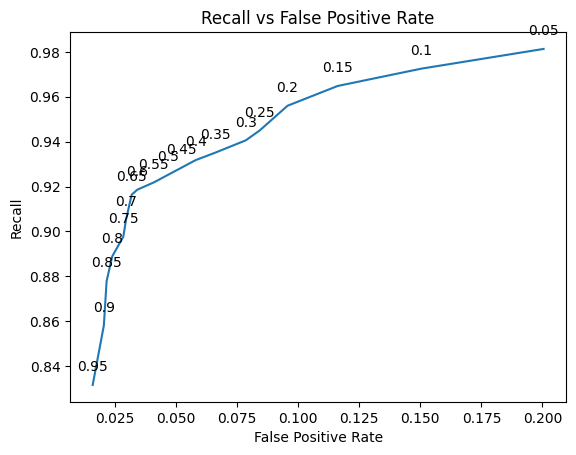

Free memory: 31.35 GB
Total memory: 31.74 GB


In [2]:
# TODO: add code to predict on val and test tensors

from data_extraction import FireDataset
from prediction import get_metrics
VAL_DATA_NAME = f"{MODEL_NAME}_val"
TEST_DATA_NAME =f"{MODEL_NAME}_test"
val_images = FireDataset.init_from_data_name(VAL_DATA_NAME)
test_images = FireDataset.init_from_data_name(TEST_DATA_NAME)

inference_model =  my_image_model.image_model.model
print_mem_data()
with torch.no_grad():
    val_image_predictions = inference_model(val_images.images.to(device))
print_mem_data()
# use recall and FPR curve to determine best threshold for binarizing predictions
recalls = []
fprs = []
thresholds = [n/100 for n in range(5, 100, 5)] # threshold above which a prediction probabiltiy is considered fire
for threshold in thresholds:
    recall, false_positive_rate, _ = get_metrics(val_image_predictions, val_images.labels, threshold)
    recalls.append(recall)
    fprs.append(false_positive_rate)


# plot recall vs false positive rate
import matplotlib.pyplot as plt
plt.plot(fprs, recalls)

# add point lables with threshold
for i, txt in enumerate(thresholds):
    plt.annotate(txt, (fprs[i], recalls[i]), textcoords="offset points", xytext=(0,10), ha='center')

plt.xlabel('False Positive Rate')
plt.ylabel('Recall')
plt.title('Recall vs False Positive Rate')
plt.show()

# cleanup
del val_images
del val_image_predictions
torch.cuda.empty_cache()  # Frees GPU memory from deleted tensors
print_mem_data()

In [3]:
best_threshold = 0.9


# get results on test videos
with torch.no_grad():
    test_fire_predictions =inference_model(test_images.images.to(device))
test_recall, test_fpr, test_accuracy = get_metrics(test_fire_predictions, test_images.labels, best_threshold)

print("Test Accuracy: ", test_accuracy)
print("Test Recall: ", test_recall)
print("Test False Positive Rate: ", test_fpr)

#cleanup
del test_fire_predictions
del test_images
torch.cuda.empty_cache()  # Frees GPU memory from deleted tensors
print_mem_data()


Test Accuracy:  0.9044158747903857
Test Recall:  0.8349726775956284
Test False Positive Rate:  0.02288329519450801
Free memory: 31.35 GB
Total memory: 31.74 GB


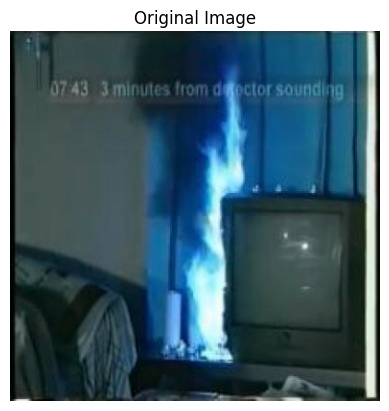

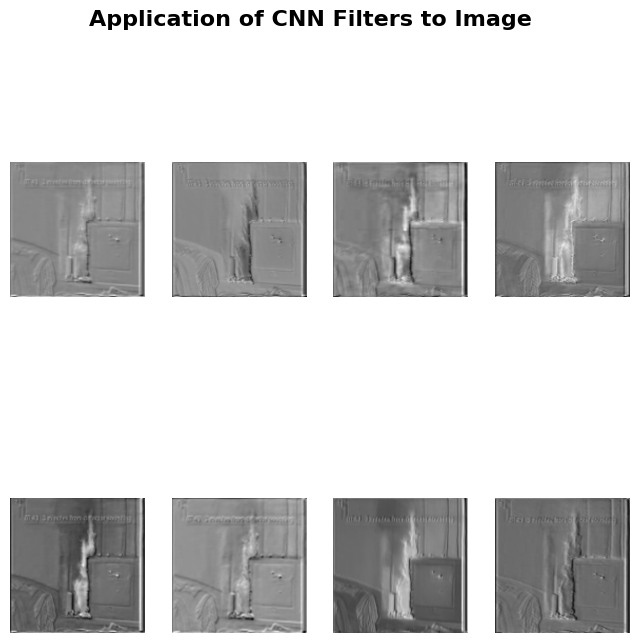

In [4]:
import torchvision
from train_cnn import visualize_layer_output
# visualize the first layer

random_img = torchvision.io.read_image("data/Fire_Detection.v1.coco/train/middle_-3105-_jpg.rf.9334fddaf1854aebbf93b979ca6eac0c.jpg")
visualize_layer_output(inference_model.trained_model.convolutional_layers[0], random_img, TRANSFORM, device = device)